In [1]:
import jax, os
import jax.numpy as jnp
import xcquinox as xce
import pyscf
from pyscf import gto,dft,scf
import matplotlib.pyplot as plt
import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Notebook Goal: Plotting the Separate Exchange/Correlation Enhancement Factors Learned by Networks

For this, we need density inputs to:
- feed to pyscf to get the energy density, which we will divide by the corresponding HEG density
- generate the descriptors with which we predict a network energy density, to divide by the same HEG density

In [2]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = jnp.einsum('ij,ij->j',drho[:,0],drho[:,0]), jnp.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = jnp.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= jnp.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b
    
def get_data_synth(xcmodel, xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = jnp.concatenate([[0],jnp.exp(jnp.linspace(-10,4,n))])
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = jnp.concatenate([jnp.exp(jnp.linspace(jnp.log((s/100)+1e-8),8,n))])
        else:
            a_grid = jnp.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = jnp.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = jnp.asarray(rho)
    
    tdrho = xcmodel.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True, mf=mf, dm=dm)
    


    tFxc = jnp.array(fxc)
    return tdrho[0], tFxc

def get_data(mol, xcmodel, xc_func, localnet=None):
    print('mol: ', mol.atom)
    try:
        mf = scf.UKS(mol)
    except:
        mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    ao = mf._numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    if len(dm.shape) == 2:
        #artificially spin-polarize
        dm = np.array([0.5*dm, 0.5*dm])
    print('New DM shape: {}'.format(dm.shape))
    print('ao.shape', ao.shape)

    if localnet.spin_scaling:
        print('spin scaling, indicates exchange network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
        print('fxc with xc_func = {} = {}'.format(fxc_a, xc_func))
        print(f'rho_a.shape={rho_alpha.shape}, rho_b.shape={rho_beta.shape}')
        print(f'fxc_a.shape={fxc_a.shape}, fxc_b.shape={fxc_b.shape}')

        if mol.spin != 0 and sum(mol.nelec)>1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            rho = jnp.concatenate([rho_alpha, rho_beta], axis=-1)
            fxc = jnp.concatenate([fxc_a, fxc_b])
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
        else:
            print('NOT (mol.spin != 0 and sum(mol.nelec) > 1)')
            rho = rho_alpha
            fxc = fxc_a
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
    else:    
        print('no spin scaling, indicates correlation network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        print('exc with xc_func = {} = {}'.format(exc, xc_func))
        fxc = exc/mf._numint.eval_xc('LDA_C_PW',(rho_alpha, rho_beta), spin=1)[0] -1
        rho = jnp.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = jnp.array(mf.make_rdm1())
    print('get_data, dm shape = {}'.format(dm.shape))
    ao_eval = jnp.array(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    print(f'ao_eval.shape={ao_eval.shape}')
    rho = jnp.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)        
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    print('rho shape', rho.shape)
    if dm.ndim == 3:
        rho_filt = (jnp.sum(rho0,axis=0) > 1e-6)
    else:
        rho_filt = (rho0 > 1e-6)
    print('rho_filt shape:', rho_filt.shape)

    
    mf.converged=True
    tdrho = xcmodel.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=localnet.spin_scaling, mf=mf, dm=dm)
    print(f'tdrho.shape={tdrho.shape}')
    if localnet.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            #tdrho not returned in a spin-polarized form regardless,
            #but the enhancement factors sampled as polarized, so double
            tdrho = jnp.concatenate([tdrho,tdrho], axis=1)
            rho_filt2 = rho_filt.copy()
            rho_filt = jnp.concatenate([rho_filt]*2)
            print(f'tdrho.shape={tdrho.shape}')
            print(f'rho_filt.shape={rho_filt.shape}')
        elif sum(mol.nelec) == 1:
            pass
    try:
        tdrho = tdrho[rho_filt]
        tFxc = jnp.array(fxc)[rho_filt]
    except:
        tdrho = tdrho[:, rho_filt, :]
        tFxc = jnp.array(fxc)[rho_filt]
    return tdrho, tFxc

def get_data_exc(mol, xcmodel, xc_func, localnet=None, xorc=None):
    print('mol: ', mol.atom)
    try:
        mf = scf.UKS(mol)
    except:
        mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    ao = mf._numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    if len(dm.shape) == 2:
        #artificially spin-polarize
        dm = np.array([0.5*dm, 0.5*dm])
    print('New DM shape: {}'.format(dm.shape))
    print('ao.shape', ao.shape)

    #depending on the x or c type, choose the generation of the exchange or correlation density
    if xorc == 'x':
        print('Exchange contribution only')
        xc_func = xc_func+','
        if xc_func.lower() == 'pbe0,':
            print('PBE0 detected. changing xc_func to be combination of HF and PBE')
            xc_func = '0.25*HF + 0.75*PBE,'
        print(xc_func)
    elif xorc == 'c':
        print('Correlation contribution only')
        xc_func = ','+xc_func
        if xc_func.lower() == ',pbe0':
            print('PBE0 detected. Changing correlation to be just PBE')
            xc_func = ',pbe'
        print(xc_func)
    if localnet.spin_scaling:
        print('spin scaling')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]
        print('fxc with xc_func = {} = {}'.format(fxc_a, xc_func))
        print(f'rho_a.shape={rho_alpha.shape}, rho_b.shape={rho_beta.shape}')
        print(f'fxc_a.shape={fxc_a.shape}, fxc_b.shape={fxc_b.shape}')

        if mol.spin != 0 and sum(mol.nelec)>1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            rho = jnp.concatenate([rho_alpha, rho_beta], axis=-1)
            fxc = jnp.concatenate([fxc_a, fxc_b])
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
        else:
            print('NOT (mol.spin != 0 and sum(mol.nelec) > 1)')
            rho = rho_alpha
            fxc = fxc_a
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
    else:    
        print('no spin scaling')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        print('exc with xc_func = {} = {}'.format(exc, xc_func))
        fxc = exc
        rho = jnp.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = jnp.array(mf.make_rdm1())
    print('get_data, dm shape = {}'.format(dm.shape))
    ao_eval = jnp.array(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    print(f'ao_eval.shape={ao_eval.shape}')
    rho = jnp.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)        
    rho0 = rho[0,0]

    print('rho shape', rho.shape)
    if dm.ndim == 3:
        rho_filt = (jnp.sum(rho0,axis=0) > 1e-6)
    else:
        rho_filt = (rho0 > 1e-6)
    print('rho_filt shape:', rho_filt.shape)

    
    mf.converged=True
    tdrho = xcmodel.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=localnet.spin_scaling, mf=mf, dm=dm)
    print(f'get descriptors tdrho.shape={tdrho.shape}')
    if localnet.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            #tdrho not returned in a spin-polarized form regardless,
            #but the enhancement factors sampled as polarized, so double
            if len(tdrho.shape) == 3:
                print('concatenating spin channels along axis=0')
                tdrho = jnp.concatenate([tdrho[0],tdrho[1]], axis=0)
            else:
                print('concatenating along axis=0')
                tdrho = jnp.concatenate([tdrho, tdrho], axis=0)
            rho_filt = jnp.concatenate([rho_filt]*2)
            print(f'tdrho.shape={tdrho.shape}')
            print(f'rho_filt.shape={rho_filt.shape}')
        else:
            #spin == 0 or hydrogen
            tdrho = tdrho[0]
            
    try:
        tdrho = tdrho[rho_filt]
        tFxc = jnp.array(fxc)[rho_filt]
    except:
        tdrho = tdrho[:, rho_filt, :]
        tFxc = jnp.array(fxc)[rho_filt]
    return tdrho, tFxc


level_dict = {'GGA':2, 'MGGA':3, 'NONLOCAL':4}

x_lob_level_dict = {'GGA': 1.804, 'MGGA': 1.174, 'NONLOCAL': 1.174}

In [3]:
def get_gamma(rho, s):
    return (s*2*(3*jnp.pi**2)**(1/3)*rho**(4/3))**2
    
def get_tau(rho, gamma, alpha):
    uniform_factor = (3/10)*(3*jnp.pi**2)**(2/3)
    return (gamma/(8*rho))+(uniform_factor*rho**(5/3))*alpha

def unpol_input(rho, gamma, tau):
    return .5*rho, .5*rho, 0.25*gamma, 0.25*gamma, 0.25*gamma, 0*tau, 0*tau, 0.5*tau, 0.5*tau

def libxc_input(rho, gamma, tau):
    return rho, jnp.sqrt(gamma/3),  jnp.sqrt(gamma/3),  jnp.sqrt(gamma/3), tau , tau

In [4]:
def old_plot_fxc(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None, only = None):
    
    if only is not None:
        saved_models = {}
        for model_name in models:
            gm = models[model_name].grid_models
            saved_models[model_name] = gm
            models[model_name].grid_models = gm[only:only+1]
    if alpha_range is None:
        alpha_range_= [1]
    else:
        alpha_range_= alpha_range
    idx = 0
    for  _, rs_val in enumerate(rs):
        for alpha in alpha_range_:
            rho_val = 3/(4*np.pi*rs_val**3)
            s = torch.linspace(s_range[0], s_range[1],300)
            rho = torch.Tensor([rho_val]*len(s))
            gamma = get_gamma(rho, s)
            tau = get_tau(rho, gamma, alpha)
            
            inp = torch.stack(unpol_input(rho, gamma, tau),dim=-1)
            inp_libxc = torch.stack(libxc_input(rho, gamma,tau),dim=-1).detach().numpy().T
        
            
            e_heg = dft.libxc.eval_xc("LDA_X",inp_libxc,spin=0, deriv=1)[0]
                
            for model_name, ls, lw in zip(models,['-','--',':','-.',':'],[2] + [1]*4):

                if ls == '-' and len(rs) > 1: 
                    l = '$r_s = ${}'.format(rs_val)
                elif ls == '-' and len(alpha_range_) > 1:
                    if alpha_range is not None:
                        l = ' $\\alpha = $ {}'.format(alpha)
                else:
                    l = ''
                libxc = False
                if model_name[-4:] == '_LXC':
                    libxc = True
                if model_name[-2:] == '_S' or libxc:
                    method = models[model_name]
                else:
                    #models[model_name].exx_a = torch.nn.Parameter(torch.Tensor([0]))
                    method = models[model_name].eval_grid_models
                    
                if libxc:
                    exc = dft.libxc.eval_xc(method, inp_libxc, spin=0, deriv=1)[0]
                else:
                    exc = method(inp).squeeze().detach().numpy()
               
               
#                 e_heg = models[model_name].heg_model(rho).squeeze().detach().numpy()
                ax = plot(s, exc/e_heg,
                     label = l, color='C{}'.format(idx),ls = ls,lw=lw)
                if len(rs) == 1 and (alpha_range is None or  len(alpha_range) == 1):
                    idx+=1
            idx+=1
            
    for idx,(model_name, ls) in enumerate(zip(models,['-','--',':','-.',':'])):  
        c = 'gray' if len(rs) > 1 or len(alpha_range_) > 1 else 'C{}'.format(idx)
        plot([],label=model_name,color=c,ls=ls)

    ylabel('$F_{xc}$ (a.u.)')
    xlabel('s')
    legend()
    
    if only is not None:
        for model_name in models:
            models[model_name].grid_models = saved_models[model_name]

In [5]:
def e_heg(rs, s_range = [0, 3], alpha_range = None):
    #generate the HEG energy density
    alpha_range = alpha_range if alpha_range else [1]
    rs = [rs] if type(rs) == float else rs
    return_dct = {alpha: [] for alpha in alpha_range}
    for ridx, rv in enumerate(rs):
        for alpha in alpha_range:
            rho_val = 3/(4*np.pi*rv**3)
            s = jnp.linspace(s_range[0], s_range[1],300)
            rho = jnp.array([rho_val]*len(s))
            gamma = get_gamma(rho, s)
            tau = get_tau(rho, gamma, alpha)

            inp = jnp.stack(unpol_input(rho, gamma, tau), axis=-1)
            inp_libxc = jnp.stack(libxc_input(rho, gamma, tau), axis=0)
            print(f'inp.size = {inp.size}, inp_libxc.size = {inp_libxc.size}')
            print(f'inp.shape = {inp.shape}, inp_libxc.shape = {inp_libxc.shape}')
            e_heg_xc = dft.libxc.eval_xc('LDA_X', inp_libxc, spin=0, deriv=1)[0]
            e_heg_x = dft.libxc.eval_xc('LDA_X,', inp_libxc, spin=0, deriv=1)[0]
            e_heg_c = dft.libxc.eval_xc('LDA_C_PW,', inp_libxc, spin=0, deriv=1)[0]

            return_dct[alpha] = (inp, inp_libxc, e_heg_x, e_heg_c, e_heg_xc)    
            
    return return_dct   

def get_net_fxc(xc_type, level, modelpath, rs, s_range = [0, 3], alpha_range = None):
    ehdct = e_heg(rs=rs, s_range=s_range, alpha_range=alpha_range)
    ehdks = sorted(list(ehdct.keys()))
    return_dct = {k: [] for k in ehdks}
    net, params = xce.net.get_net(xorc=xc_type, level=level, net_path=modelpath)
    xc = xce.xc.eXC(grid_models=[net], heg_mult=True, level= {'GGA':2, 'MGGA':3, 'NONLOCAL':4, 'NL':4}[level.upper()])
    for k in ehdks:
        # if params['spin_scaling']:
        #     print('Spin scaling flagged on network.')
        #     exc = net(jnp.concatenate([0.5*ehdct[k][0].T, 0.5*ehdct[k][0].T], axis=-1))
        # else:
        #     print('Spin scaling flagged on network.')
        #     exc = net(ehdct[k][0].T)
        print(f'Generating enhancement factor for {modelpath} at alpha={k}')
        exc = xc.eval_grid_models(ehdct[k][0])[:, 0]
        div = {'x':ehdct[k][2], 'c':ehdct[k][3], 'xc':ehdct[k][4]}[xc_type.lower()]
        print(f'exc.shape = {exc.shape}, div.shape = {div.shape}')
        return_dct[k] = exc/div
    return return_dct

def get_xc_fxc(xcfunc, rs, s_range = [0, 3], alpha_range = None):
    ehdct = e_heg(rs=rs, s_range=s_range, alpha_range=alpha_range)
    ehdks = sorted(list(ehdct.keys()))
    return_dct = {k: [] for k in ehdks}
    if ',' in xcfunc:
        xc_type = 'x' if xcfunc[-1] == ',' else 'c'
    else:
        xc_type = 'xc'
    for k in ehdks:    
        print(f'Generating enhancement factor for {xcfunc} at alpha={k}')
        exc = dft.libxc.eval_xc(xcfunc, ehdct[k][1])[0]
        div = {'x':ehdct[k][2], 'c':ehdct[k][3], 'xc':ehdct[k][4]}[xc_type.lower()]
        print(f'exc.shape = {exc.shape}, div.shape = {div.shape}')
        return_dct[k] = exc/div
    return return_dct


In [6]:
alphas = [0, 1, 10]
s_range = [0, 3]
ehdct = e_heg(rs=1.0, s_range=s_range, alpha_range=alphas)

inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)


In [7]:
[i.shape for i in ehdct[0]]

[(300, 9), (6, 300), (300,), (300,), (300,)]

In [8]:
alphas = [0, 1, 10]
s_range = [0, 3]
s = jnp.linspace(s_range[0], s_range[1],300)
#for pure functionals below
pbe_fxcs = get_xc_fxc('PBE', 1.0, alpha_range=alphas)
pbe_fxs = get_xc_fxc('PBE,', 1.0, alpha_range=alphas)
pbe_fcs = get_xc_fxc(',PBE', 1.0, alpha_range=alphas)
scan_fxcs = get_xc_fxc('SCAN', 1.0, alpha_range=alphas)
scan_fxs = get_xc_fxc('SCAN,', 1.0, alpha_range=alphas)
scan_fcs = get_xc_fxc(',SCAN', 1.0, alpha_range=alphas)
pbe0_fxcs = get_xc_fxc('PBE0', 1.0, alpha_range=alphas)
pbe0_fxs = get_xc_fxc('PBE0,', 1.0, alpha_range=alphas)
pbe0_fcs = get_xc_fxc(',PBE0', 1.0, alpha_range=alphas)

inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
Generating enhancement factor for PBE at alpha=0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for PBE at alpha=1
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for PBE at alpha=10
exc.shape = (300,), div.shape = (300,)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
Generating enhancement factor for PBE, at alpha=0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for PBE, at alpha=1
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor

In [9]:
#here, we get the enhancement factors for the separate networks
#random first
rd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran'
nets = sorted(os.listdir(rd))
ran_fxs = {}
ran_fcs = {}
for net in nets:
    print(net)
    nsplit = net.split('_')
    if nsplit[-1] == 'nl':
        continue
    if nsplit[0] == 'x':
        ran_fxs[net] = get_net_fxc(xc_type = 'x', level = nsplit[-1].upper(), modelpath = os.path.join(rd, net), rs=1.0, alpha_range=alphas)
    elif nsplit[0] == 'c':
        ran_fcs[net] = get_net_fxc(xc_type = 'c', level = nsplit[-1].upper(), modelpath = os.path.join(rd, net), rs=1.0, alpha_range=alphas)


c_3_16_c0_gga
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
SINGLE NETFILE MATCH FOUND. DESERIALIZING...
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran/c_3_16_c0_gga at alpha=0
eC.__call__, rho shape: (300, 3)
eC.__call__, rho nans: 0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran/c_3_16_c0_gga at alpha=1
eC.__call__, rho shape: (300, 3)
eC.__call__, rho nans: 0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/ran/c_3_16_c0_gga at alpha=10
eC.__call__, rho shape: (300, 3)
eC.__call__, rho nans: 0
exc.shape = (300,), div.shape =

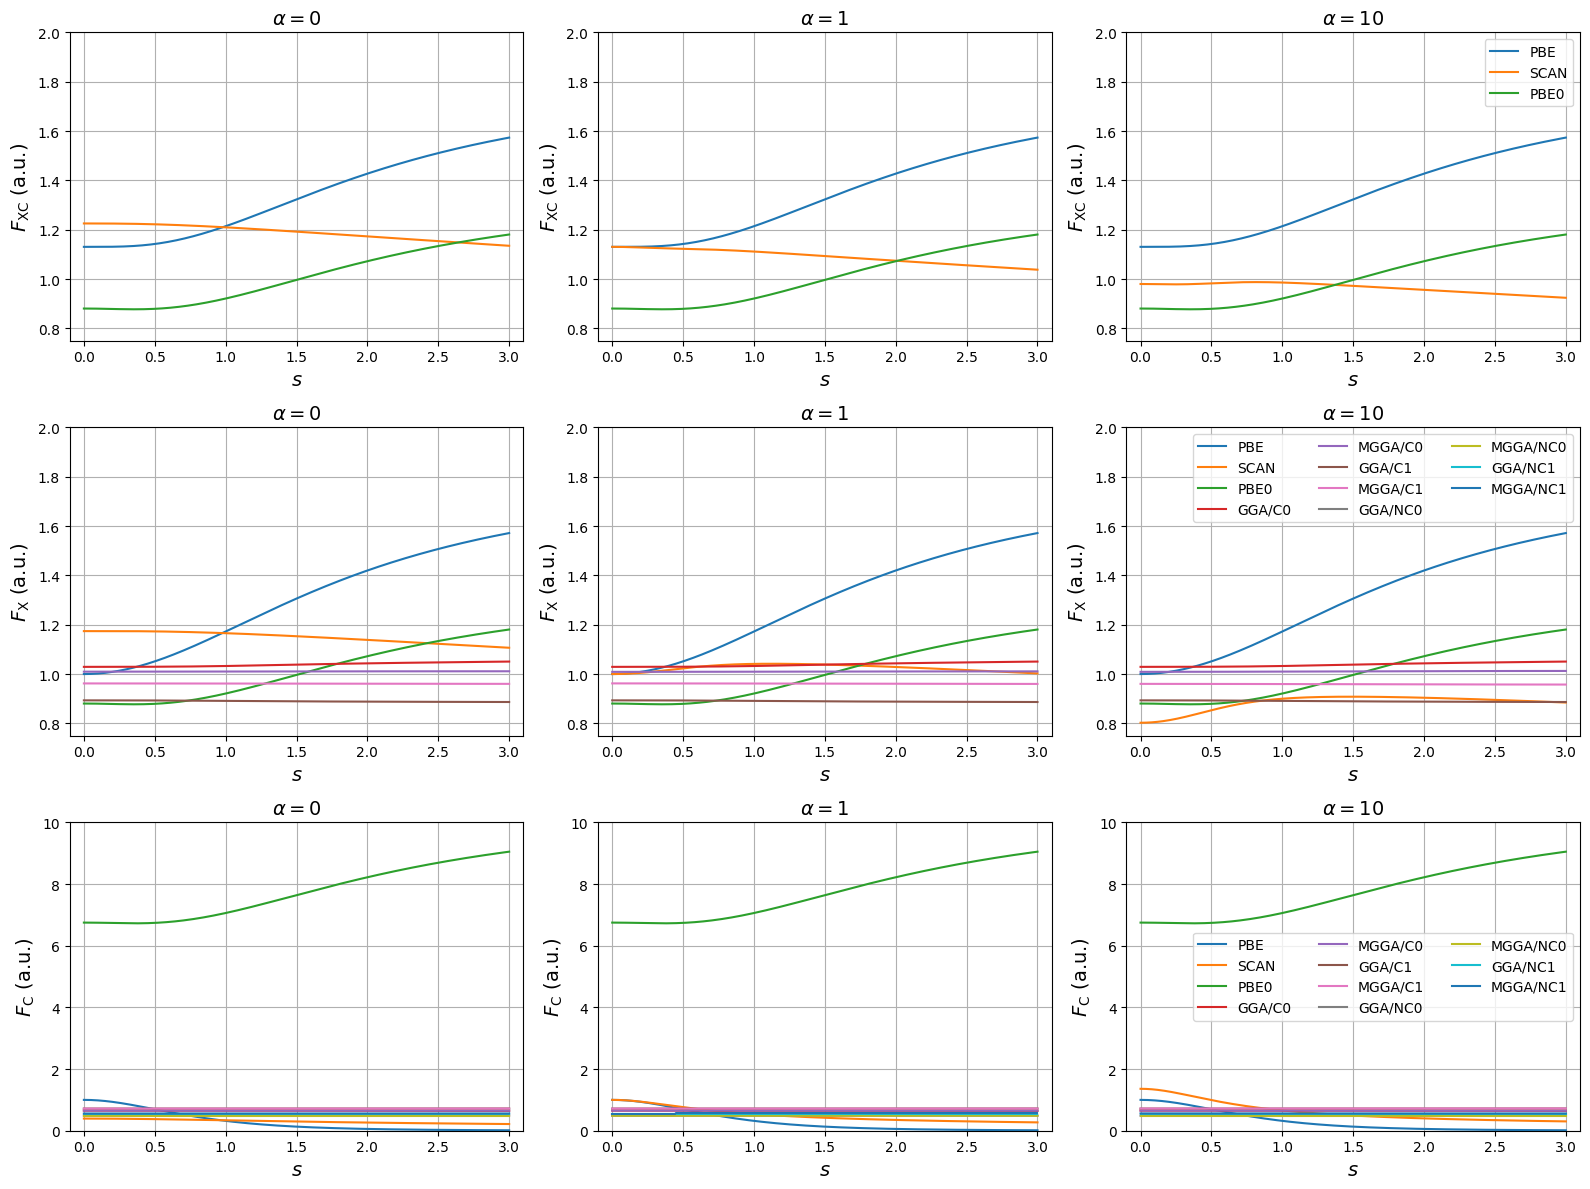

In [10]:
f = plt.figure(figsize=(16,12))
ax0xc = f.add_subplot(331)
ax1xc = f.add_subplot(332)
ax10xc = f.add_subplot(333)
ax0x = f.add_subplot(334)
ax1x = f.add_subplot(335)
ax10x = f.add_subplot(336)
ax0c = f.add_subplot(337)
ax1c = f.add_subplot(338)
ax10c = f.add_subplot(339)
axs = [ax0xc, ax1xc, ax10xc, ax0x, ax1x, ax10x, ax0c, ax1c, ax10c]
a0s = [ax0xc, ax0x, ax0c]
a1s = [ax1xc, ax1x, ax1c]
a10s = [ax10xc, ax10x, ax10c]

for ax in a0s:
    ax.set_title('$\\alpha = 0$', fontsize=14)
for ax in a1s:
    ax.set_title('$\\alpha = 1$', fontsize=14)
for ax in a10s:
    ax.set_title('$\\alpha = 10$', fontsize=14)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$s$', fontsize=14)
    ax.set_ylim(0.75, 2)
    ax.set_xlim(s[0]-0.1, s[-1]+0.1)
xcaxs = axs[:3]
xaxs = axs[3:-3]
caxs = axs[-3:]
for ax in caxs:
    ax.set_ylim(0, 10)
for ax in xcaxs:
    ax.set_ylabel('$F_\mathrm{XC}$ (a.u.)', fontsize=14)
for ax in xaxs:
    ax.set_ylabel('$F_\mathrm{X}$ (a.u.)', fontsize=14)
for ax in caxs:
    ax.set_ylabel('$F_\mathrm{C}$ (a.u.)', fontsize=14)


for idx, xcax in enumerate(xcaxs):
    xcax.plot(s, pbe_fxcs[alphas[idx]], label='PBE')
    xcax.plot(s, scan_fxcs[alphas[idx]], label='SCAN')
    xcax.plot(s, pbe0_fxcs[alphas[idx]], label='PBE0')
for idx, xax in enumerate(xaxs):
    xax.plot(s, pbe_fxs[alphas[idx]], label='PBE')
    xax.plot(s, scan_fxs[alphas[idx]], label='SCAN')
    xax.plot(s, pbe0_fxs[alphas[idx]], label='PBE0')
    for k, v in ran_fxs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        xax.plot(s, v[alphas[idx]], label=lab)
for idx, cax in enumerate(caxs):
    cax.plot(s, pbe_fcs[alphas[idx]], label='PBE')
    cax.plot(s, scan_fcs[alphas[idx]], label='SCAN')
    cax.plot(s, pbe0_fcs[alphas[idx]], label='PBE0')
    for k, v in ran_fcs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        cax.plot(s, v[alphas[idx]], label=lab)

xcaxs[-1].legend()
xaxs[-1].legend(ncol=3)
caxs[-1].legend(ncol=3)
plt.tight_layout()

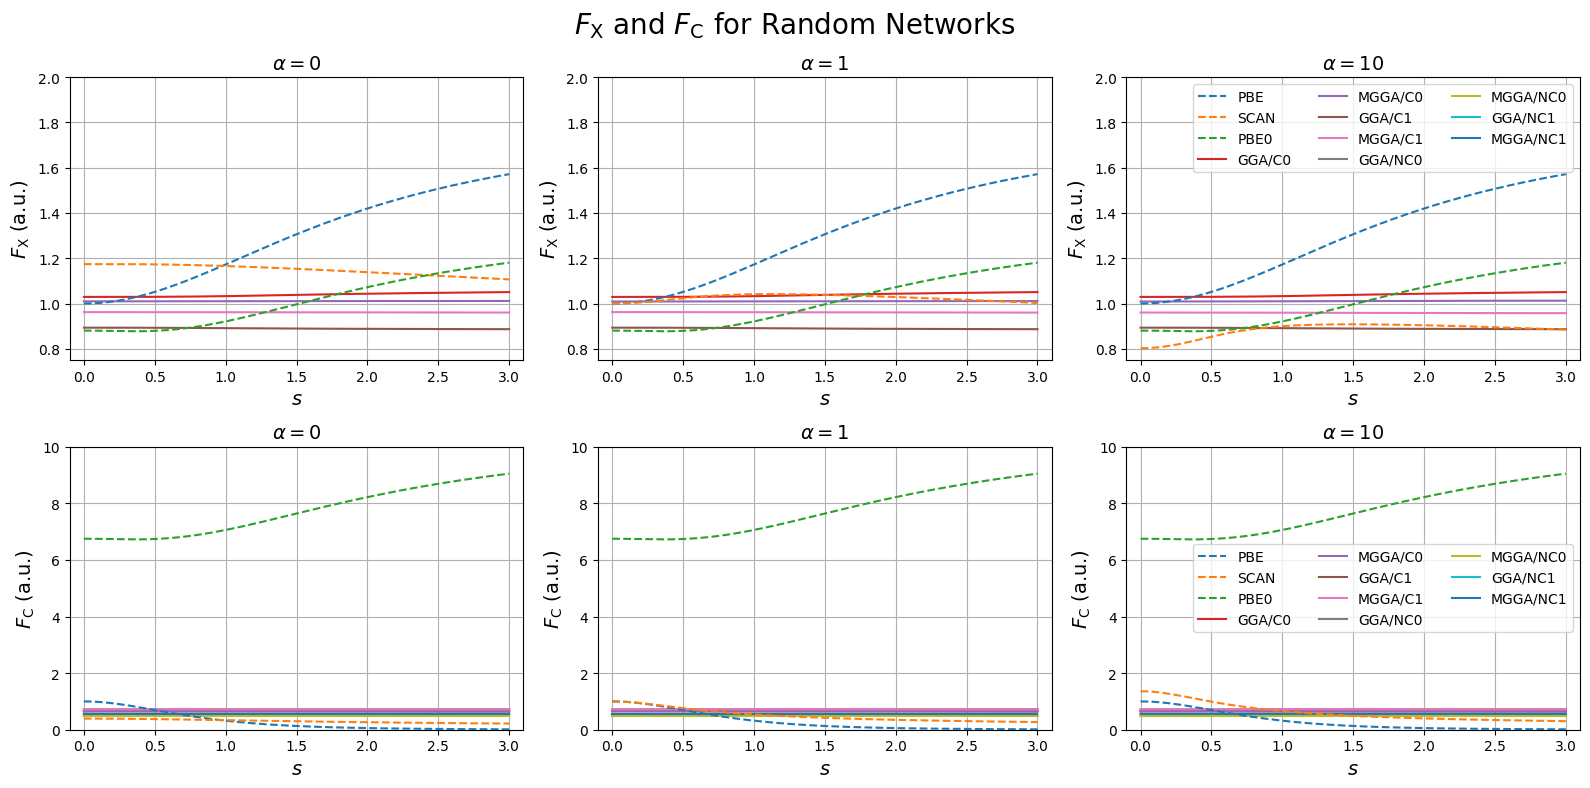

In [26]:
f = plt.figure(figsize=(16,8))
ax0x = f.add_subplot(231)
ax1x = f.add_subplot(232)
ax10x = f.add_subplot(233)
ax0c = f.add_subplot(234)
ax1c = f.add_subplot(235)
ax10c = f.add_subplot(236)
axs = [ax0x, ax1x, ax10x, ax0c, ax1c, ax10c]
a0s = [ax0x, ax0c]
a1s = [ax1x, ax1c]
a10s = [ax10x, ax10c]

for ax in a0s:
    ax.set_title('$\\alpha = 0$', fontsize=14)
for ax in a1s:
    ax.set_title('$\\alpha = 1$', fontsize=14)
for ax in a10s:
    ax.set_title('$\\alpha = 10$', fontsize=14)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$s$', fontsize=14)
    ax.set_ylim(0.75, 2)
    ax.set_xlim(s[0]-0.1, s[-1]+0.1)
xaxs = axs[:-3]
caxs = axs[-3:]
for ax in caxs:
    ax.set_ylim(0, 10)
for ax in xaxs:
    ax.set_ylabel('$F_\mathrm{X}$ (a.u.)', fontsize=14)
for ax in caxs:
    ax.set_ylabel('$F_\mathrm{C}$ (a.u.)', fontsize=14)


for idx, xax in enumerate(xaxs):
    xax.plot(s, pbe_fxs[alphas[idx]], '--', label='PBE', zorder=5)
    xax.plot(s, scan_fxs[alphas[idx]], '--', label='SCAN', zorder=5)
    xax.plot(s, pbe0_fxs[alphas[idx]], '--', label='PBE0', zorder=5)
    for k, v in ran_fxs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        xax.plot(s, v[alphas[idx]], label=lab)
for idx, cax in enumerate(caxs):
    cax.plot(s, pbe_fcs[alphas[idx]], '--', label='PBE', zorder=5)
    cax.plot(s, scan_fcs[alphas[idx]], '--', label='SCAN', zorder=5)
    cax.plot(s, pbe0_fcs[alphas[idx]], '--', label='PBE0', zorder=5)
    for k, v in ran_fcs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        cax.plot(s, v[alphas[idx]], label=lab)

xcaxs[-1].legend()
xaxs[-1].legend(ncol=3)
caxs[-1].legend(ncol=3)
plt.suptitle('$F_\mathrm{X}$ and $F_\mathrm{C}$ for Random Networks', fontsize=20)
plt.tight_layout()

In [11]:
#here, we get the enhancement factors for the separate networks
#pbe/scan/pbe0 now
# pd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe'
pd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe2'
sd = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/scan'
p0d = '/home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe0'
nets = sorted(os.listdir(pd))
npbe_fxs = {}
npbe_fcs = {}
nscan_fxs = {}
nscan_fcs = {}
npbe0_fxs = {}
npbe0_fcs = {}
for net in nets:
    print(net)
    nsplit = net.split('_')
    if nsplit[-1] == 'nl':
        continue
    if nsplit[0] == 'x':
        npbe_fxs[net] = get_net_fxc(xc_type = 'x', level = nsplit[-1].upper(), modelpath = os.path.join(pd, net), rs=1.0, alpha_range=alphas)
        nscan_fxs[net] = get_net_fxc(xc_type = 'x', level = nsplit[-1].upper(), modelpath = os.path.join(sd, net), rs=1.0, alpha_range=alphas)
        npbe0_fxs[net] = get_net_fxc(xc_type = 'x', level = nsplit[-1].upper(), modelpath = os.path.join(p0d, net), rs=1.0, alpha_range=alphas)
    elif nsplit[0] == 'c':
        npbe_fcs[net] = get_net_fxc(xc_type = 'c', level = nsplit[-1].upper(), modelpath = os.path.join(pd, net), rs=1.0, alpha_range=alphas)
        nscan_fcs[net] = get_net_fxc(xc_type = 'c', level = nsplit[-1].upper(), modelpath = os.path.join(sd, net), rs=1.0, alpha_range=alphas)
        npbe0_fcs[net] = get_net_fxc(xc_type = 'c', level = nsplit[-1].upper(), modelpath = os.path.join(p0d, net), rs=1.0, alpha_range=alphas)


c_3_16_c0_gga
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
inp.size = 2700, inp_libxc.size = 1800
inp.shape = (300, 9), inp_libxc.shape = (6, 300)
NETFILE MATCHES FOUND -- MULTIPLE. SELECTING LAST ONE.
ATTEMPTING TO DESERIALIZE xc.eqx.2480
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe2/c_3_16_c0_gga at alpha=0
eC.__call__, rho shape: (300, 3)
eC.__call__, rho nans: 0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe2/c_3_16_c0_gga at alpha=1
eC.__call__, rho shape: (300, 3)
eC.__call__, rho nans: 0
exc.shape = (300,), div.shape = (300,)
Generating enhancement factor for /home/awills/Documents/Research/xcquinox/scripts/script_data/ctests/pt/pbe2/c_3_16_c0_gga at alpha=10
eC.__call__, rho shape: (300,

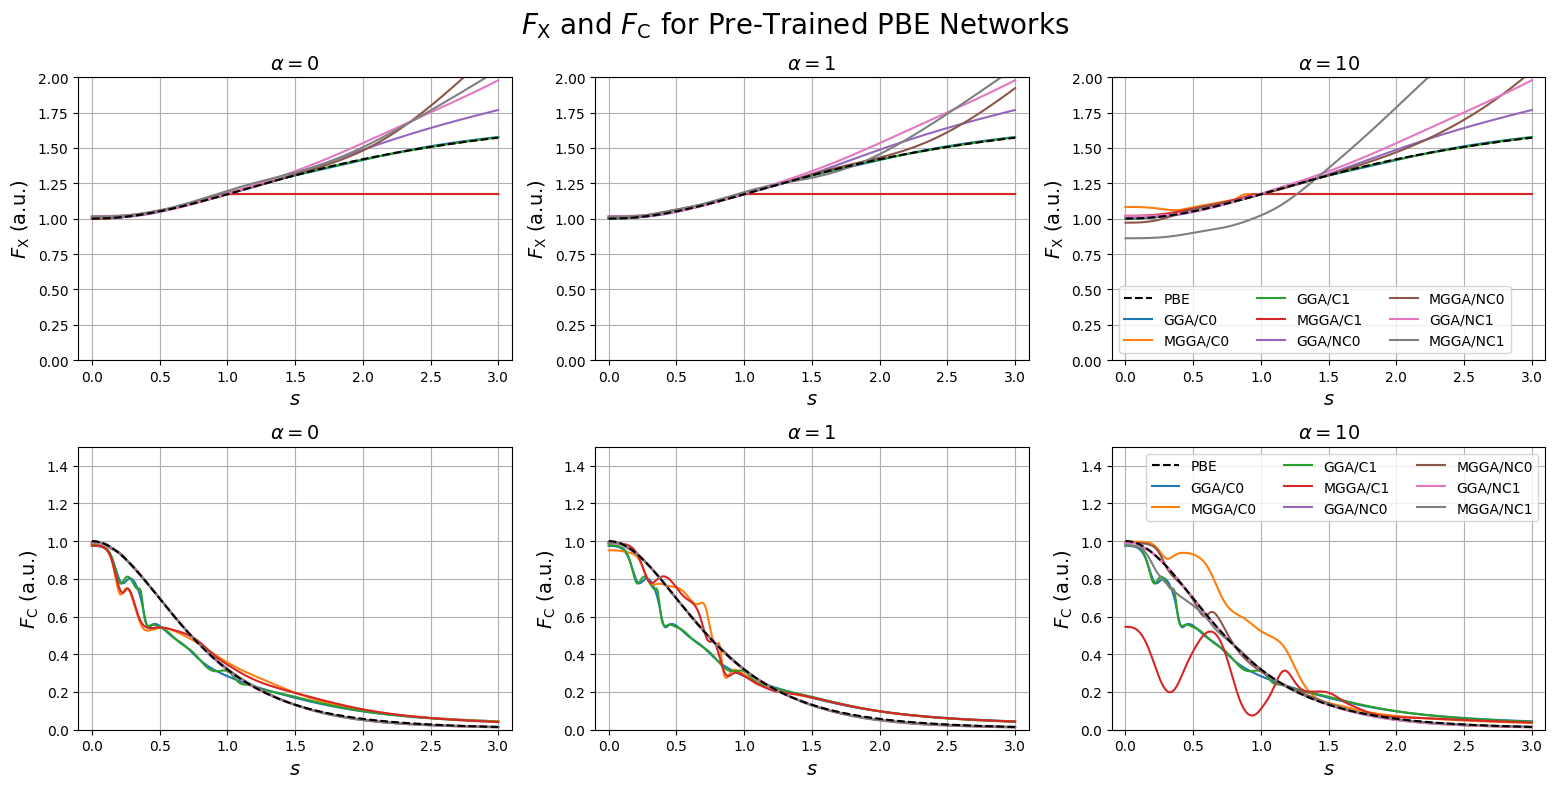

In [29]:
f = plt.figure(figsize=(16,8))
ax0x = f.add_subplot(231)
ax1x = f.add_subplot(232)
ax10x = f.add_subplot(233)
ax0c = f.add_subplot(234)
ax1c = f.add_subplot(235)
ax10c = f.add_subplot(236)
axs = [ax0x, ax1x, ax10x, ax0c, ax1c, ax10c]
a0s = [ax0x, ax0c]
a1s = [ax1x, ax1c]
a10s = [ax10x, ax10c]

for ax in a0s:
    ax.set_title('$\\alpha = 0$', fontsize=14)
for ax in a1s:
    ax.set_title('$\\alpha = 1$', fontsize=14)
for ax in a10s:
    ax.set_title('$\\alpha = 10$', fontsize=14)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$s$', fontsize=14)
    ax.set_ylim(0.0, 2)
    ax.set_xlim(s[0]-0.1, s[-1]+0.1)
xaxs = axs[:-3]
caxs = axs[-3:]
for ax in caxs:
    ax.set_ylim(0, 1.5)
for ax in xaxs:
    ax.set_ylabel('$F_\mathrm{X}$ (a.u.)', fontsize=14)
for ax in caxs:
    ax.set_ylabel('$F_\mathrm{C}$ (a.u.)', fontsize=14)
for idx, xax in enumerate(xaxs):
    xax.plot(s, pbe_fxs[alphas[idx]], 'k--', label='PBE', zorder=5)
    # xax.plot(s, scan_fxs[alphas[idx]], label='SCAN')
    # xax.plot(s, pbe0_fxs[alphas[idx]], label='PBE0')
    for k, v in npbe_fxs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        xax.plot(s, v[alphas[idx]], label=lab)
for idx, cax in enumerate(caxs):
    cax.plot(s, pbe_fcs[alphas[idx]], 'k--', label='PBE', zorder=5)
    # cax.plot(s, scan_fcs[alphas[idx]], label='SCAN')
    # cax.plot(s, pbe0_fcs[alphas[idx]], label='PBE0')
    for k, v in npbe_fcs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        cax.plot(s, v[alphas[idx]], label=lab)

xcaxs[-1].legend()
xaxs[-1].legend(ncol=3)
caxs[-1].legend(ncol=3)
plt.suptitle('$F_\mathrm{X}$ and $F_\mathrm{C}$ for Pre-Trained PBE Networks', fontsize=20)
plt.tight_layout()

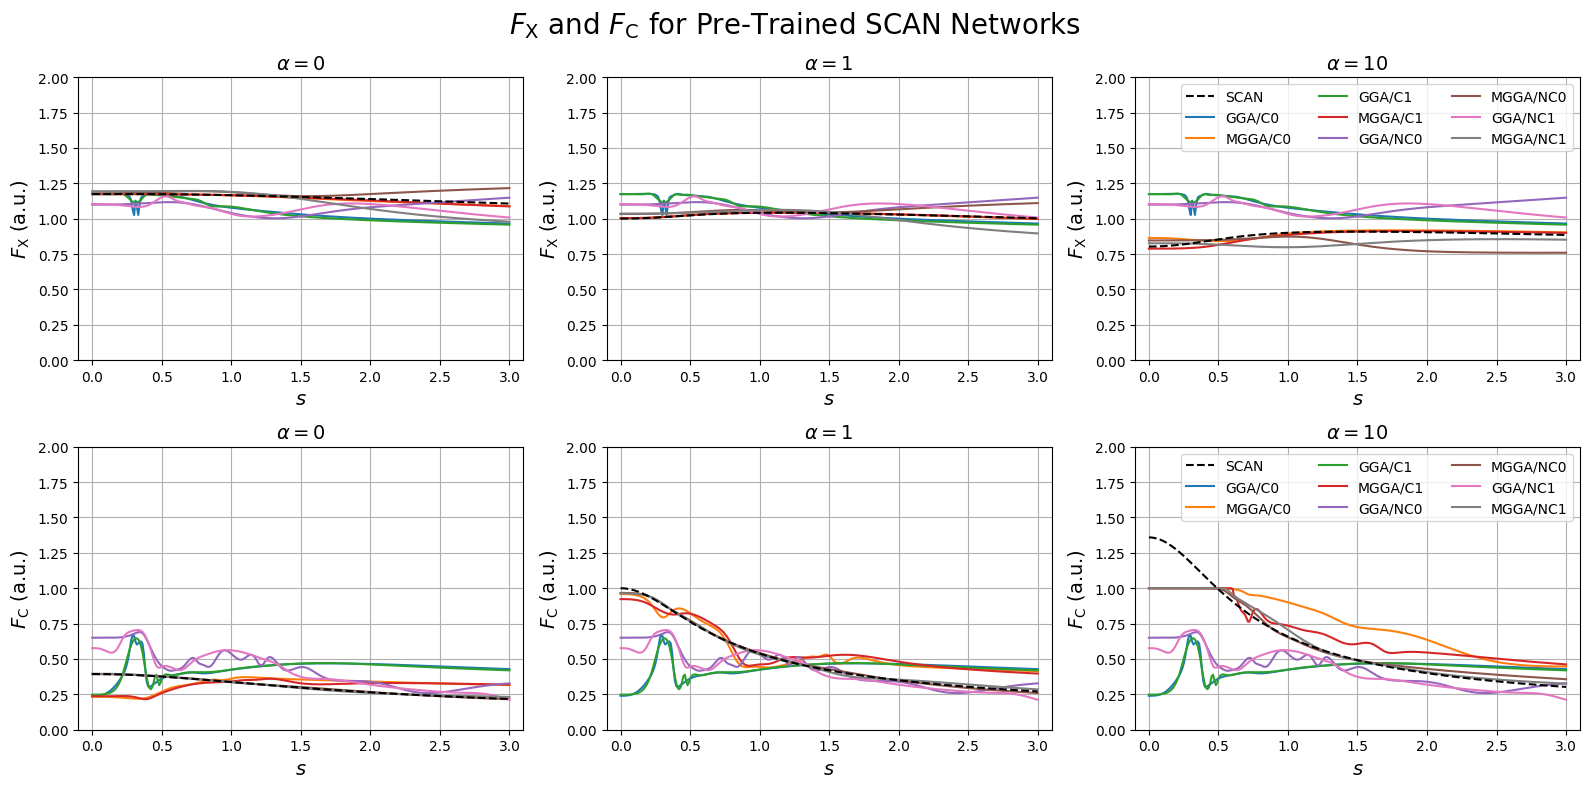

In [30]:
f = plt.figure(figsize=(16,8))
ax0x = f.add_subplot(231)
ax1x = f.add_subplot(232)
ax10x = f.add_subplot(233)
ax0c = f.add_subplot(234)
ax1c = f.add_subplot(235)
ax10c = f.add_subplot(236)
axs = [ax0x, ax1x, ax10x, ax0c, ax1c, ax10c]
a0s = [ax0x, ax0c]
a1s = [ax1x, ax1c]
a10s = [ax10x, ax10c]

for ax in a0s:
    ax.set_title('$\\alpha = 0$', fontsize=14)
for ax in a1s:
    ax.set_title('$\\alpha = 1$', fontsize=14)
for ax in a10s:
    ax.set_title('$\\alpha = 10$', fontsize=14)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$s$', fontsize=14)
    ax.set_ylim(0.0, 2)
    ax.set_xlim(s[0]-0.1, s[-1]+0.1)
xaxs = axs[:-3]
caxs = axs[-3:]
for ax in caxs:
    ax.set_ylim(0, 2)
for ax in xaxs:
    ax.set_ylabel('$F_\mathrm{X}$ (a.u.)', fontsize=14)
for ax in caxs:
    ax.set_ylabel('$F_\mathrm{C}$ (a.u.)', fontsize=14)
for idx, xax in enumerate(xaxs):
    # xax.plot(s, pbe_fxs[alphas[idx]], label='PBE')
    xax.plot(s, scan_fxs[alphas[idx]], 'k--', label='SCAN', zorder=5)
    # xax.plot(s, pbe0_fxs[alphas[idx]], label='PBE0')
    for k, v in nscan_fxs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        xax.plot(s, v[alphas[idx]], label=lab)
for idx, cax in enumerate(caxs):
    # cax.plot(s, pbe_fcs[alphas[idx]], label='PBE')
    cax.plot(s, scan_fcs[alphas[idx]], 'k--', label='SCAN', zorder=5)
    # cax.plot(s, pbe0_fcs[alphas[idx]], label='PBE0')
    for k, v in nscan_fcs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        cax.plot(s, v[alphas[idx]], label=lab)

xcaxs[-1].legend()
xaxs[-1].legend(ncol=3)
caxs[-1].legend(ncol=3)
plt.suptitle('$F_\mathrm{X}$ and $F_\mathrm{C}$ for Pre-Trained SCAN Networks', fontsize=20)
plt.tight_layout()

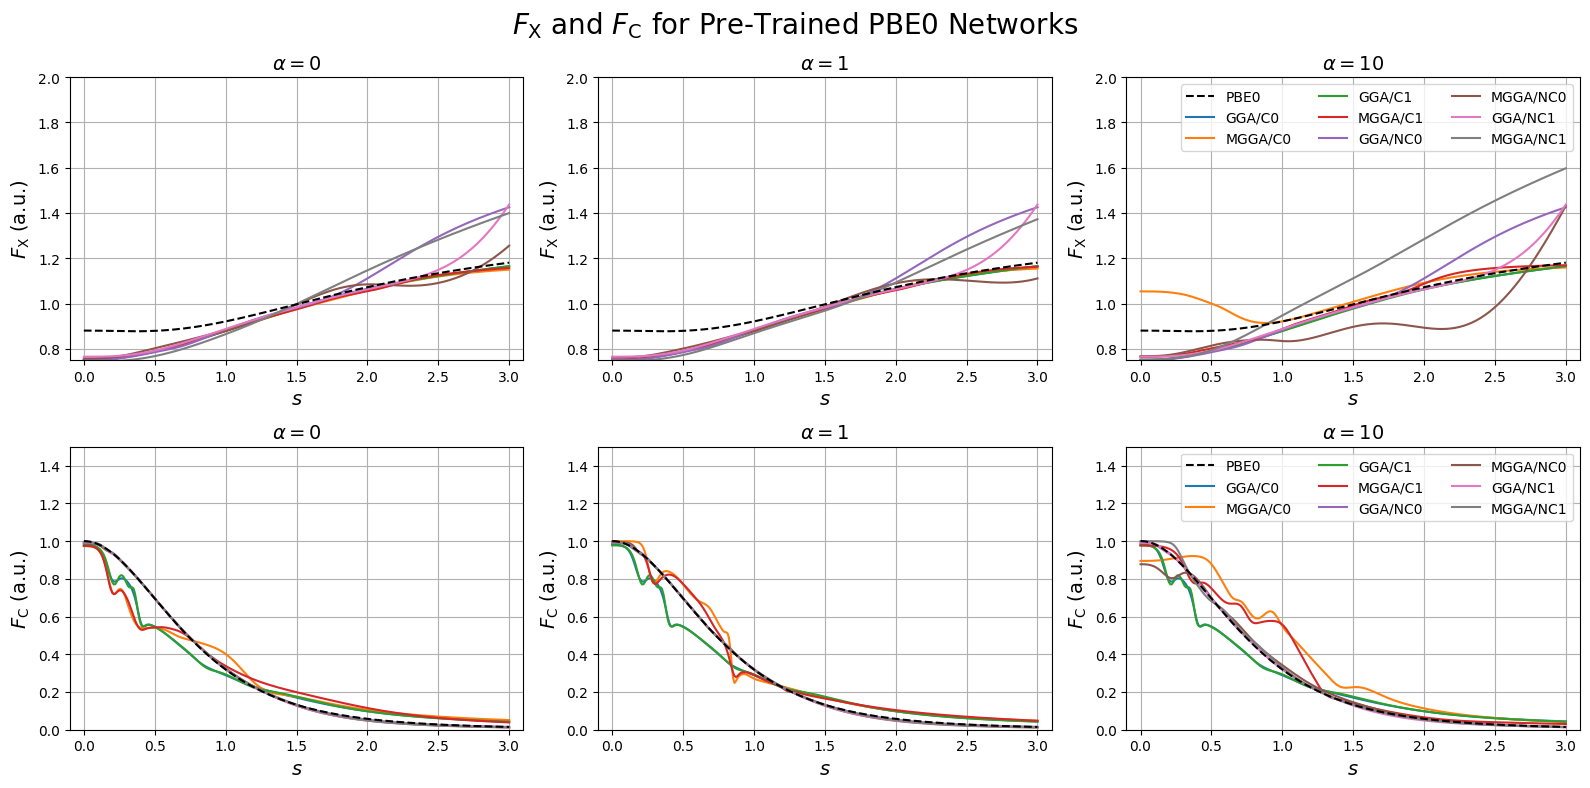

In [31]:
f = plt.figure(figsize=(16,8))
ax0x = f.add_subplot(231)
ax1x = f.add_subplot(232)
ax10x = f.add_subplot(233)
ax0c = f.add_subplot(234)
ax1c = f.add_subplot(235)
ax10c = f.add_subplot(236)
axs = [ax0x, ax1x, ax10x, ax0c, ax1c, ax10c]
a0s = [ax0x, ax0c]
a1s = [ax1x, ax1c]
a10s = [ax10x, ax10c]

for ax in a0s:
    ax.set_title('$\\alpha = 0$', fontsize=14)
for ax in a1s:
    ax.set_title('$\\alpha = 1$', fontsize=14)
for ax in a10s:
    ax.set_title('$\\alpha = 10$', fontsize=14)
for ax in axs:
    ax.grid()
    ax.set_xlabel('$s$', fontsize=14)
    ax.set_ylim(0.75, 2)
    ax.set_xlim(s[0]-0.1, s[-1]+0.1)
xaxs = axs[:-3]
caxs = axs[-3:]
for ax in caxs:
    ax.set_ylim(0, 1.5)
for ax in xaxs:
    ax.set_ylabel('$F_\mathrm{X}$ (a.u.)', fontsize=14)
for ax in caxs:
    ax.set_ylabel('$F_\mathrm{C}$ (a.u.)', fontsize=14)
for idx, xax in enumerate(xaxs):
    # xax.plot(s, pbe_fxs[alphas[idx]], label='PBE')
    # xax.plot(s, scan_fxs[alphas[idx]], label='SCAN')
    xax.plot(s, pbe0_fxs[alphas[idx]],'k--', label='PBE0', zorder=5)
    for k, v in npbe0_fxs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        xax.plot(s, v[alphas[idx]], label=lab)
for idx, cax in enumerate(caxs):
    # cax.plot(s, pbe_fcs[alphas[idx]], label='PBE')
    # cax.plot(s, scan_fcs[alphas[idx]], label='SCAN')
    cax.plot(s, pbe_fcs[alphas[idx]],'k--', label='PBE0', zorder=5)
    for k, v in npbe0_fcs.items():
        ksplit = k.split('_')
        lab = '/'.join([ksplit[-1].upper(), ksplit[-2].upper()])
        cax.plot(s, v[alphas[idx]], label=lab)

xcaxs[-1].legend()
xaxs[-1].legend(ncol=3)
caxs[-1].legend(ncol=3)
plt.suptitle('$F_\mathrm{X}$ and $F_\mathrm{C}$ for Pre-Trained PBE0 Networks', fontsize=20)
plt.tight_layout()